# Example Script for Logistic Regression for Fishing Detection

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score


Load data.  This dataset contains coordinates, speeds, and courses for fishing vessels, hand labeled to be fishing or not fishing.

In [11]:
data = np.load('/Users/mnksmith/Documents/Oceana_MPA_data/kristina_trawl_Trawlers.measures.labels.npz')
df = pd.DataFrame(data['x'])
list(df)

['measure_coursestddev_43200',
 'measure_speedavg_86400',
 'measure_coursestddev_1800_log',
 'measure_coursestddev_10800_log',
 'measure_courseavg_43200',
 'measure_cos_course',
 'measure_daylightavg_1800',
 'measure_coursestddev_21600',
 'measure_speedstddev_1800',
 'measure_distance_from_port',
 'measure_count_1800',
 'course',
 'measure_sin_course',
 'measure_speedstddev_10800',
 'measure_speedavg_21600',
 'speed',
 'is_fishing',
 'measure_pos_86400',
 'measure_daylightavg_43200',
 'measure_latavg_86400',
 'measure_latavg_10800',
 'distance_from_port',
 'measure_latavg_1800',
 'measure_pos_1800',
 'measure_lonavg_3600',
 'measure_count_3600',
 'lon',
 'measure_speedavg_10800',
 'measure_latavg_3600',
 'measure_coursestddev_43200_log',
 'measure_latavg_21600',
 'measure_daylightavg_10800',
 'measure_count_86400',
 'measure_count_21600',
 'measure_speedstddev_86400_log',
 'measure_lonavg_1800',
 'measure_courseavg_10800',
 'measure_speedstddev_3600',
 'measure_lonavg_10800',
 'measure

## Some preliminary exploration:

In [12]:
df.groupby('is_fishing').mean()

,measure_coursestddev_43200,measure_speedavg_86400,measure_coursestddev_1800_log,measure_coursestddev_10800_log,measure_courseavg_43200,measure_cos_course,measure_daylightavg_1800,measure_coursestddev_21600,measure_speedstddev_1800,measure_distance_from_port,...,measure_daylight,measure_coursestddev_1800,measure_pos_21600,measure_coursestddev_3600_log,measure_speedavg_1800,measure_lonavg_43200,measure_speedstddev_1800_log,measure_courseavg_21600,measure_coursestddev_10800,measure_speed
is_fishing,,,,,,,,,,,,,,,,,,,,,
0.0,0.329647,0.742965,-2.077196,-1.463860,0.549997,0.033999,0.507943,0.249315,0.008394,0.989764,...,0.513161,0.064668,0.083291,-1.924135,0.712483,-35.974912,-2.466032,0.549934,0.184166,0.711909
1.0,0.545111,0.711700,-1.668870,-0.739401,0.491566,0.006685,0.516783,0.450399,0.014567,1.000000,...,0.521646,0.086162,0.072853,-1.485516,0.737045,-29.195121,-2.193470,0.492170,0.335319,0.736545


/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


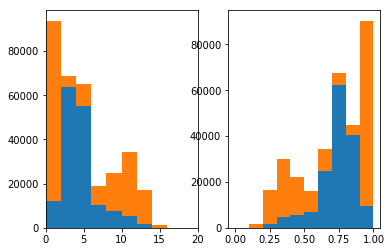

In [13]:
plt.figure()
plt.tight_layout()
plt.subplot(1,2,1)
plt.xlim(0,20)
fishy = df.loc[df.is_fishing==1]
unfishy = df.loc[df.is_fishing==0]
#plt.hist(fishy.speed, range=(0,20))
plt.hist([fishy['speed'],unfishy['speed']], stacked=True, range = (0,20))
plt.subplot(1,2,2)
#measure_speed = 1.0 - min(1, speed-over-ground / 17)
plt.hist([fishy['measure_speed'],unfishy['measure_speed']], stacked=True, range = (0,1))
plt.show()

The "measure_speed" feature is equivalent to the speed-over-ground, capped at 17 knots.

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


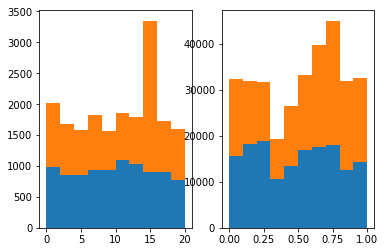

In [14]:
plt.figure()
plt.tight_layout()
plt.subplot(1,2,1)
plt.hist([fishy['course'],unfishy['course']], stacked=True, range = (0,20))
plt.subplot(1,2,2)
#measure_course = course-over-ground / 360)
plt.hist([fishy['measure_course'],unfishy['measure_course']], stacked=True, range = (0,1))
plt.show()

The "measure_course" feature is equivalent to the course-over-ground, divided by 360.

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


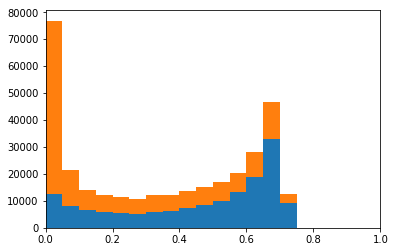

In [15]:
plt.figure()
plt.xlim(0,1)
plt.hist([fishy['measure_coursestddev_21600'],unfishy['measure_coursestddev_21600']], stacked=True, bins=20, range=(0,1))
plt.show()

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


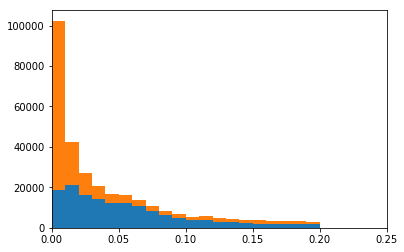

In [16]:
plt.figure()
plt.xlim(0,0.25)
plt.hist([fishy['measure_speedstddev_21600'],unfishy['measure_speedstddev_21600']], stacked=True, bins=20, range=(0,0.2))
plt.show()

/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mnksmith/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


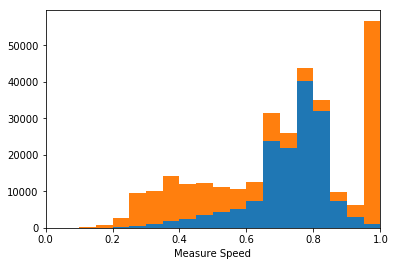

In [17]:
plt.figure()
plt.xlim(0,1)
plt.hist([fishy['measure_speedavg_21600'].values,unfishy['measure_speedavg_21600'].values], stacked=True, bins=20, range=(0,1))
plt.xlabel('Measure Speed')
#plt.show()
plt.savefig('example_feature.png', dpi=300)

In [9]:
df = fishy[['measure_speedavg_21600']].reset_index()
df['measure_speedavg_21600_not_Fishing'] = unfishy['measure_speedavg_21600']
df.head(10)

,index,measure_speedavg_21600,measure_speedavg_21600_not_Fishing
0,4226,0.776471,0.996078
1,4227,0.776471,0.997059
2,4228,0.764706,0.996471
3,4229,0.758824,0.996078
4,4276,0.841176,0.995502
5,4277,0.858824,0.995425
6,4278,0.869412,0.996791
7,4279,0.876471,0.997059
8,4280,0.881699,0.997285
9,4281,0.881176,0.997479


In [27]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('MPA_feature_example.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Now plot a scatter matrix to look for corellations between some select features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ab252b0>,
      dtype=object)

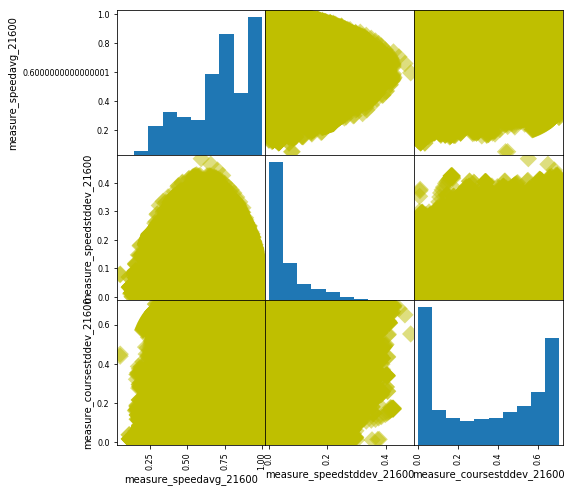

In [18]:
df_slim = df[['measure_speedavg_21600','measure_speedstddev_21600','measure_coursestddev_21600']].copy()
pd.plotting.scatter_matrix(df_slim, c = 'y', figsize = [8, 8], s=150, marker = 'D')

## Logistic Regression Model

Each of the key features (average speed, standard deviation of speed, and standard deviation of course) are averaged over 0.5, 1, 3, 6, 12, and 24 hours to fill out the list of features.  Powers (up to 6) of each of these features are included to uncover non-linear behavior.  For example, from the plots above it is clear that vessels moving very slowly or very quickly are less likely to be fishing, while there's a "sweet spot" in the middle.  A linear fit will not capture this behavior.

In [19]:
times = [1800,3600,10800,21600,43200,86400]
for p in range(2,7):
    for time in times:
        avgspd = 'measure_speedavg_' + str(time)
        stdspd = 'measure_speedstddev_' + str(time) + '_log'
        stdcs = 'measure_coursestddev_' + str(time) + '_log'
        avgspd_p = 'measure_speedavg_' + str(time) + '_' + str(p)
        stdspd_p = 'measure_speedstddev_' + str(time) + '_log_' + str(p)
        stdcs_p = 'measure_coursestddev_' + str(time) + '_log_' + str(p)
        
        df[avgspd_p] = pow(df[avgspd],p)
        df[stdspd_p] = pow(df[stdspd],p)
        df[stdcs_p] = pow(df[stdcs],p)
        
list(df)

['measure_coursestddev_43200',
 'measure_speedavg_86400',
 'measure_coursestddev_1800_log',
 'measure_coursestddev_10800_log',
 'measure_courseavg_43200',
 'measure_cos_course',
 'measure_daylightavg_1800',
 'measure_coursestddev_21600',
 'measure_speedstddev_1800',
 'measure_distance_from_port',
 'measure_count_1800',
 'course',
 'measure_sin_course',
 'measure_speedstddev_10800',
 'measure_speedavg_21600',
 'speed',
 'is_fishing',
 'measure_pos_86400',
 'measure_daylightavg_43200',
 'measure_latavg_86400',
 'measure_latavg_10800',
 'distance_from_port',
 'measure_latavg_1800',
 'measure_pos_1800',
 'measure_lonavg_3600',
 'measure_count_3600',
 'lon',
 'measure_speedavg_10800',
 'measure_latavg_3600',
 'measure_coursestddev_43200_log',
 'measure_latavg_21600',
 'measure_daylightavg_10800',
 'measure_count_86400',
 'measure_count_21600',
 'measure_speedstddev_86400_log',
 'measure_lonavg_1800',
 'measure_courseavg_10800',
 'measure_speedstddev_3600',
 'measure_lonavg_10800',
 'measure

In [20]:
y, X = dmatrices('is_fishing ~ measure_speedavg_1800 + measure_speedavg_3600 + measure_speedavg_10800 + \
                    measure_speedavg_21600 + measure_speedavg_43200 + measure_speedavg_86400 + \
                    measure_speedstddev_1800_log + measure_speedstddev_3600_log + measure_speedstddev_10800_log + \
                    measure_speedstddev_21600_log + measure_speedstddev_43200_log + measure_speedstddev_86400_log + \
                    measure_coursestddev_1800_log + measure_coursestddev_3600_log + measure_coursestddev_10800_log + \
                    measure_coursestddev_21600_log + measure_coursestddev_43200_log + measure_coursestddev_86400_log + \
                    measure_speedavg_1800_2 + measure_speedavg_3600_2 + measure_speedavg_10800_2 + \
                    measure_speedavg_21600_2 + measure_speedavg_43200_2 + measure_speedavg_86400_2 + \
                    measure_speedstddev_1800_log_2 + measure_speedstddev_3600_log_2 + measure_speedstddev_10800_log_2 + \
                    measure_speedstddev_21600_log_2 + measure_speedstddev_43200_log_2 + measure_speedstddev_86400_log_2 + \
                    measure_coursestddev_1800_log_2 + measure_coursestddev_3600_log_2 + measure_coursestddev_10800_log_2 + \
                    measure_coursestddev_21600_log_2 + measure_coursestddev_43200_log_2 + measure_coursestddev_86400_log_2 + \
                    measure_speedavg_1800_3 + measure_speedavg_3600_3 + measure_speedavg_10800_3 + \
                    measure_speedavg_21600_3 + measure_speedavg_43200_3 + measure_speedavg_86400_3 + \
                    measure_speedstddev_1800_log_3 + measure_speedstddev_3600_log_3 + measure_speedstddev_10800_log_3 + \
                    measure_speedstddev_21600_log_3 + measure_speedstddev_43200_log_3 + measure_speedstddev_86400_log_3 + \
                    measure_coursestddev_1800_log_3 + measure_coursestddev_3600_log_3 + measure_coursestddev_10800_log_3 + \
                    measure_coursestddev_21600_log_3 + measure_coursestddev_43200_log_3 + measure_coursestddev_86400_log_3 + \
                    measure_speedavg_1800_4 + measure_speedavg_3600_4 + measure_speedavg_10800_4 + \
                    measure_speedavg_21600_4 + measure_speedavg_43200_4 + measure_speedavg_86400_4 + \
                    measure_speedstddev_1800_log_4 + measure_speedstddev_3600_log_4 + measure_speedstddev_10800_log_4 + \
                    measure_speedstddev_21600_log_4 + measure_speedstddev_43200_log_4 + measure_speedstddev_86400_log_4 + \
                    measure_coursestddev_1800_log_4 + measure_coursestddev_3600_log_4 + measure_coursestddev_10800_log_4 + \
                    measure_coursestddev_21600_log_4 + measure_coursestddev_43200_log_4 + measure_coursestddev_86400_log_4 + \
                    measure_speedavg_1800_5 + measure_speedavg_3600_5 + measure_speedavg_10800_5 + \
                    measure_speedavg_21600_5 + measure_speedavg_43200_5 + measure_speedavg_86400_5 + \
                    measure_speedstddev_1800_log_5 + measure_speedstddev_3600_log_5 + measure_speedstddev_10800_log_5 + \
                    measure_speedstddev_21600_log_5 + measure_speedstddev_43200_log_5 + measure_speedstddev_86400_log_5 + \
                    measure_coursestddev_1800_log_5 + measure_coursestddev_3600_log_5 + measure_coursestddev_10800_log_5 + \
                    measure_coursestddev_21600_log_5 + measure_coursestddev_43200_log_5 + measure_coursestddev_86400_log_5 + \
                    measure_speedavg_1800_6 + measure_speedavg_3600_6 + measure_speedavg_10800_6 + \
                    measure_speedavg_21600_6 + measure_speedavg_43200_6 + measure_speedavg_86400_6 + \
                    measure_speedstddev_1800_log_6 + measure_speedstddev_3600_log_6 + measure_speedstddev_10800_log_6 + \
                    measure_speedstddev_21600_log_6 + measure_speedstddev_43200_log_6 + measure_speedstddev_86400_log_6 + \
                    measure_coursestddev_1800_log_6 + measure_coursestddev_3600_log_6 + measure_coursestddev_10800_log_6 + \
                    measure_coursestddev_21600_log_6 + measure_coursestddev_43200_log_6 + measure_coursestddev_86400_log_6' ,
                  df, return_type="dataframe")
print(X.columns)
y = np.ravel(y)

Index(['Intercept', 'measure_speedavg_1800', 'measure_speedavg_3600',
       'measure_speedavg_10800', 'measure_speedavg_21600',
       'measure_speedavg_43200', 'measure_speedavg_86400',
       'measure_speedstddev_1800_log', 'measure_speedstddev_3600_log',
       'measure_speedstddev_10800_log',
       ...
       'measure_speedstddev_10800_log_6', 'measure_speedstddev_21600_log_6',
       'measure_speedstddev_43200_log_6', 'measure_speedstddev_86400_log_6',
       'measure_coursestddev_1800_log_6', 'measure_coursestddev_3600_log_6',
       'measure_coursestddev_10800_log_6', 'measure_coursestddev_21600_log_6',
       'measure_coursestddev_43200_log_6', 'measure_coursestddev_86400_log_6'],
      dtype='object', length=109)


In [21]:
model = LogisticRegression()
model = model.fit(X, y)
model.score(X, y)

0.8472178482552503

Using the powers of each feature I lifted a 78% accuracy to 88%

In [174]:
y.mean()

0.48070617439469443

If I guessed "0" every time, I'd get 52% accuracy.

Now splitting the whole thing into train and test datasets to evaluate the model:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=432)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
probas = model.predict_proba(X_test)

In [23]:
print(metrics.accuracy_score(y_test, predictions))
print(metrics.roc_auc_score(y_test, probas[:, 1]))

0.8764549692796937
0.9419180250539522


The accuracy is still 88% on the validation dataset, the same as when we trained and tested on the same set.

In [179]:
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[28710  4911]
 [ 3060 28097]]
             precision    recall  f1-score   support

        0.0       0.90      0.85      0.88     33621
        1.0       0.85      0.90      0.88     31157

avg / total       0.88      0.88      0.88     64778



In [180]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores.mean())

0.8603727355352178


Over a 10-fold cross-validation, the accuracy dips slightly, to 86%

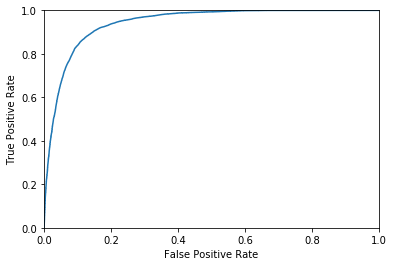

In [25]:
fpr, tpr, _ = metrics.roc_curve(y_test,probas[:,1])
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0,1)
plt.xlim(0,1)
#plt.show()

plt.savefig('roc_curve.png', dpi=300)

Finally, a ROC-curve showing how well the model performs in terms of precision and accuracy.

[0. 1. 0. ... 0. 1. 0.]
